# Predicting and Generating Texts

This notebook explores the idea of predicting items in a sequence, and then using those predictions to generate new sequences based on the probabilities.


In [1]:
import conx as cx

Using Theano backend.
ConX, version 3.6.0


## EmbeddingLayer

An EmbeddingLayer allows the system to find (or use) distributed representations for words or letters. 

First, we need a method of encoding and decoding our sequenced data. We'll begin with characters.

In [2]:
def encode(s):
    """Convert string or char into integers"""
    if len(s) == 1:
        return (1 + ord(s.lower()) - ord('a')) if s.isalpha() else 0
    else:
        return cleanup([encode(c) for c in s])

def cleanup(items):
    """Remove repeated zeros"""
    retval = []
    for i in items:
        if ((i != 0) or 
            (len(retval) == 0) or 
            (retval[-1] != 0)):
            retval.append(i)
    return retval

def decode(n):
    """Convert integers into characters"""
    if isinstance(n, (list, tuple)):
        return [decode(v) for v in n]
    elif n == 0:
        return ' '
    else:
        return chr(ord('a') + int(n) - 1)

In [3]:
encode("H")

8

In [4]:
encode("Hello, world!")

[8, 5, 12, 12, 15, 0, 23, 15, 18, 12, 4, 0]

In [5]:
encode("AaaA")

[1, 1, 1, 1]

In [6]:
decode(8)

'h'

In [7]:
decode(encode("   what's     up  doc?   "))

[' ', 'w', 'h', 'a', 't', ' ', 's', ' ', 'u', 'p', ' ', 'd', 'o', 'c', ' ']

In [8]:
"".join(decode(encode("   what's     up  doc?   ")))

' what s up doc '

### Given 1 - Predict 1

Let's start out with sequence of characers of length 1. We'll just try to predict what the next character is given a single letter. We'll start with a fairly small corpus:

In [9]:
corpus = """Four score and seven years ago our fathers brought forth on this continent, 
a new nation, conceived in Liberty, and dedicated to the proposition that all men are 
created equal. Now we are engaged in a great civil war, testing whether that nation, or 
any nation so conceived and so dedicated, can long endure. We are met on a great battle-field 
of that war. We have come to dedicate a portion of that field, as a final resting place 
for those who here gave their lives that that nation might live. It is altogether fitting 
and proper that we should do this. But, in a larger sense, we can not dedicate — we can not 
consecrate — we can not hallow — this ground. The brave men, living and dead, who struggled 
here, have consecrated it, far above our poor power to add or detract. The world will little 
note, nor long remember what we say here, but it can never forget what they did here. It is 
for us the living, rather, to be dedicated here to the unfinished work which they who fought 
here have thus far so nobly advanced. It is rather for us to be here dedicated to the great 
task remaining before us — that from these honored dead we take increased devotion to that 
cause for which they gave the last full measure of devotion — that we here highly resolve that 
these dead shall not have died in vain — that this nation, under God, shall have a new birth of 
freedom — and that government of the people, by the people, for the people, shall not perish 
from the earth."""

In [10]:
"".join(decode(encode(corpus)))

'four score and seven years ago our fathers brought forth on this continent a new nation conceived in liberty and dedicated to the proposition that all men are created equal now we are engaged in a great civil war testing whether that nation or any nation so conceived and so dedicated can long endure we are met on a great battle field of that war we have come to dedicate a portion of that field as a final resting place for those who here gave their lives that that nation might live it is altogether fitting and proper that we should do this but in a larger sense we can not dedicate we can not consecrate we can not hallow this ground the brave men living and dead who struggled here have consecrated it far above our poor power to add or detract the world will little note nor long remember what we say here but it can never forget what they did here it is for us the living rather to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced it is rat

In [11]:
len_vocab = max(encode(corpus)) + 1
len_vocab

26

In [13]:
dataset = []
encoded_corpus = encode(corpus)
for i in range(len(encoded_corpus) - 1):
    code = encoded_corpus[i]
    next_code = encoded_corpus[i + 1]
    dataset.append([[code], cx.onehot(next_code, len_vocab)])

In [16]:
net = cx.Network("Given 1 - Predict 1")
net.add(cx.Layer("input", 1), 
        cx.EmbeddingLayer("embed", 26, 64),  # in, out
        cx.FlattenLayer("flatten"),
        cx.Layer("output", 26, activation="softmax"))
net.connect()
net.compile(error="categorical_crossentropy", optimizer="adam")

In [17]:
net.dataset.load(dataset)

In [18]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=3, options=('input', 'embed', 'flatten', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

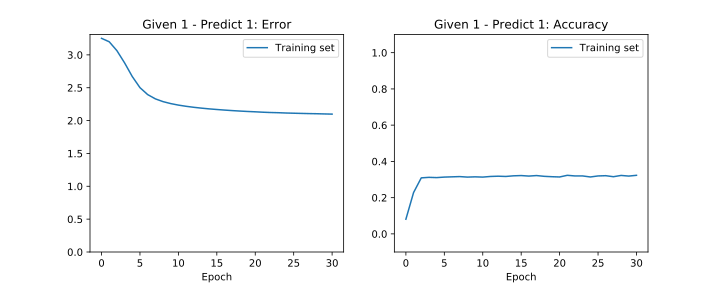

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#   30 |   2.09850 |   0.32324 
Saving network... Saved!


In [19]:
if net.saved():
    net.load()
    net.plot_results()
else:
    net.train(30, accuracy=.95, save=True)

In [23]:
def generate(net, count, len_vocab):
    retval = ""
    # start at a random point:
    inputs = cx.choice(net.dataset.inputs)
    # now we get the next, and the next, ...
    for i in range(count):
        # use the outputs as a prob distrbution
        outputs = net.propagate(inputs)
        code = cx.choice(p=outputs)
        c = decode(code)
        print(c, end="")
        retval += c
    return retval

In [24]:
generate(net, 500, len_vocab)

fhdhaittw twatbwdsnfhtapuyndodntwicnboiptndtafptnwnditiahtnyfpwiwsfthscocbnwqtlhnwwawpnnitaonejhtwagtlndathftptowdclwfawtpaafdohwioawnlwtddcwaaclettgocctehnltpttthttdoatttdgwbtodtapowviwtfacsfdvbiphbdftaltffbwttndwnardnfpcwttrifchtbfahiboatthtttoapbaowrogcgshtdahwiahtmtatfptsftstlwotgmnphaowwhaathlmcctcapaftqtttguwwwsbgcbwitphttvcwwitatfdset btirabdatawtaftbafbstfgfnataattctdrottnsaahbaagttwtdimdwttsyddgwtatgndgtttdsthsctfswhofwhgtgmctfbhoorcxsaatcahtndotpthnoalttatbwnwisobtwwdthpgalbtafhctsfedp

'fhdhaittw twatbwdsnfhtapuyndodntwicnboiptndtafptnwnditiahtnyfpwiwsfthscocbnwqtlhnwwawpnnitaonejhtwagtlndathftptowdclwfawtpaafdohwioawnlwtddcwaaclettgocctehnltpttthttdoatttdgwbtodtapowviwtfacsfdvbiphbdftaltffbwttndwnardnfpcwttrifchtbfahiboatthtttoapbaowrogcgshtdahwiahtmtatfptsftstlwotgmnphaowwhaathlmcctcapaftqtttguwwwsbgcbwitphttvcwwitatfdset btirabdatawtaftbafbstfgfnataattctdrottnsaahbaagttwtdimdwttsyddgwtatgndgtttdsthsctfswhofwhgtgmctfbhoorcxsaatcahtndotpthnoalttatbwnwisobtwwdthpgalbtafhctsfedp'

### Given 5 - Predict 1

In [25]:
net2 = cx.Network("Given 5 - Predict 1")
net2.add(cx.Layer("input", 5),
         cx.EmbeddingLayer("embed", 26, 64),
         cx.FlattenLayer("flatten"),
         cx.Layer("output", 26, activation="softmax"))
net2.connect()
net2.compile(error="categorical_crossentropy", optimizer="adam")

In [26]:
dataset = []
encoded_corpus = encode(corpus)
for i in range(len(encoded_corpus) - 5):
    code = encoded_corpus[i:i+5]
    next_code = encoded_corpus[i + 5]
    if len(code) == 5:
        dataset.append([code, cx.onehot(next_code, len_vocab)])

In [27]:
net2.dataset.load(dataset)

In [28]:
for i in range(10):
    print(i, decode(net2.dataset.inputs[i]), decode(cx.argmax(net2.dataset.targets[i])))

0 ['f', 'o', 'u', 'r', ' '] s
1 ['o', 'u', 'r', ' ', 's'] c
2 ['u', 'r', ' ', 's', 'c'] o
3 ['r', ' ', 's', 'c', 'o'] r
4 [' ', 's', 'c', 'o', 'r'] e
5 ['s', 'c', 'o', 'r', 'e']  
6 ['c', 'o', 'r', 'e', ' '] a
7 ['o', 'r', 'e', ' ', 'a'] n
8 ['r', 'e', ' ', 'a', 'n'] d
9 ['e', ' ', 'a', 'n', 'd']  


In [29]:
net2.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=3, options=('input', 'embed', 'flatten', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

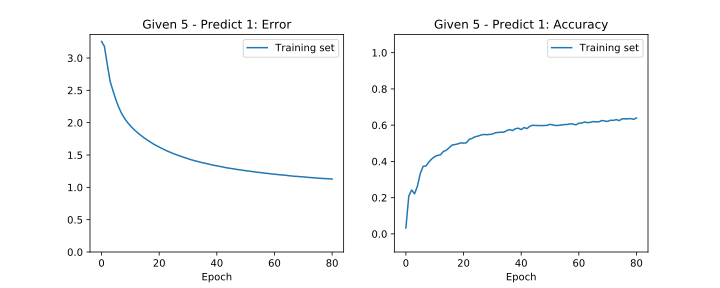

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#   80 |   1.12873 |   0.63983 
Saving network... Saved!


In [30]:
if net2.saved():
    net2.load()
    net2.plot_results()
else:
    net2.train(80, accuracy=.95, plot=True, save=True)

In [31]:
def generate2(net, count, len_vocab):
    # start at a random point:
    inputs = cx.choice(net.dataset.inputs)
    retval = "".join(decode(inputs))
    print(retval, end="")
    # now we get the next, and the next, ...
    for i in range(count):
        # use the outputs as a prob distrbution
        outputs = net.propagate(inputs)
        pickone = cx.choice(p=outputs)
        inputs = inputs[1:] + [pickone]
        c = decode(pickone)
        print(c, end="")
        retval += c
    return retval

In [32]:
generate2(net2, 1000, 26)

e peopleiby vat ongtinn ar angarese rag we the plople shere tibi fromet on which they nat bevel we iond inge hethat theasgre wer an te te areat t as allonot have ifiogr ad thas the hen nats ansur tois not hsus tofint in aly and worker measer abeveicin nation conted and poreshave diditt w us the unf refuld shall forly ghe seaded coute cattictiscrmanttonn in as reltngated titilingread dedecrten neveromed sored what we iond ingatherediin wer at bevey dedicored mant we aread ingo ged hore onot heveriend thatl ofot devicitticane wera the s all mot ung lint at an thet ca these rat se ar us te bed wh lingogat devation now efremensunfor ho here ed incaitno finglthit fitt on this thag wer gowt ha ploush newir for share ofvem ther conthe nigilllm ther forge her ghave comticin neate dedicare dist wa thes can nor lingllln fiea und wh liwis re herage wencre ted in lion trea n areso now hare deargwen reatibe med seadedicaut th se fad d se what or and dedicadedd arevot here aat of thas nfrelatg and w

'e peopleiby vat ongtinn ar angarese rag we the plople shere tibi fromet on which they nat bevel we iond inge hethat theasgre wer an te te areat t as allonot have ifiogr ad thas the hen nats ansur tois not hsus tofint in aly and worker measer abeveicin nation conted and poreshave diditt w us the unf refuld shall forly ghe seaded coute cattictiscrmanttonn in as reltngated titilingread dedecrten neveromed sored what we iond ingatherediin wer at bevey dedicored mant we aread ingo ged hore onot heveriend thatl ofot devicitticane wera the s all mot ung lint at an thet ca these rat se ar us te bed wh lingogat devation now efremensunfor ho here ed incaitno finglthit fitt on this thag wer gowt ha ploush newir for share ofvem ther conthe nigilllm ther forge her ghave comticin neate dedicare dist wa thes can nor lingllln fiea und wh liwis re herage wencre ted in lion trea n areso now hare deargwen reatibe med seadedicaut th se fad d se what or and dedicadedd arevot here aat of thas nfrelatg and 

## LSTMLayer



### Many to One Model

In [33]:
net3 = cx.Network("LSTM - Many to One")
net3.add(cx.Layer("input", 40), # sequence length
         cx.EmbeddingLayer("embed", 26, 64), # sequence_length from input
         cx.LSTMLayer("lstm", 64),
         cx.Layer("output", 26, activation="softmax"))
net3.connect()
net3.compile(loss='categorical_crossentropy', optimizer='adam')

/home/dblank/.local/lib/python3.6/site-packages/keras/layers/recurrent.py:1993: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


In [34]:
dataset = []
encoded_corpus = encode(corpus)
for i in range(len(encoded_corpus) - 40):
    code = encoded_corpus[i:i+40]
    next_code = encoded_corpus[i + 40]
    if len(code) == 40:
        dataset.append([code, cx.onehot(next_code, len_vocab)])

In [35]:
net3.dataset.load(dataset)

In [37]:
dash = net3.dashboard()
dash

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=True, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=3, options=('input', 'embed', 'lstm', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [38]:
dash.propagate(net3.dataset.inputs[0])

[0.038273777812719345,
 0.03815032169222832,
 0.03845784068107605,
 0.03826185688376427,
 0.03870994597673416,
 0.03826727718114853,
 0.03833876550197601,
 0.038511499762535095,
 0.03865756466984749,
 0.03865499049425125,
 0.038360513746738434,
 0.03830300644040108,
 0.038377050310373306,
 0.03853989392518997,
 0.03817221522331238,
 0.03834393247961998,
 0.038742661476135254,
 0.038073718547821045,
 0.03857533633708954,
 0.03845741227269173,
 0.038555778563022614,
 0.03872159868478775,
 0.03873656317591667,
 0.03813197463750839,
 0.03850744664669037,
 0.039117053151130676]

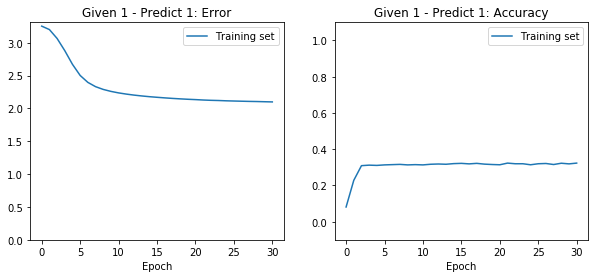

In [40]:
if net3.saved():
    net.load()
    net.plot_results()
else:
    net3.train(150, save=True)

In [41]:
def generate3(net, count, len_vocab):
    # start with a full sentence:
    inputs = cx.choice(net.dataset.inputs)
    print("".join(decode(inputs)), end="")
    for i in range(count):
        outputs = net.propagate(inputs)
        pickone = cx.choice(p=outputs)
        inputs = inputs[1:] + [pickone]
        print(decode(pickone), end="")

In [42]:
generate3(net3, 500, len_vocab)

highly resolve that these dead shall not at cate forg tan thate ond or we ive cave we rive polly whls eor wit sas lore cane niter niand deat of the hereg dead pefpyate hipnl unsg inglinginreminon dored toicon fir lony dad divhe heage ralgle ar reos id do hur lony ar bbere brare nmated wo dedidad wo af herer here vashe that late dedicathre leather that or kecamen ant genont ferecond dedicat bere the bislic thall to uk ur borke thkal therto the hieg to dishe dediondgiin ur lorcem berey od cavt thath we alled onicatint inng keveretin seo

## Many to Many LSTM


In [43]:
net4 = cx.Network("Many-to-Many LSTM")
net4.add(cx.Layer("input", None),  # None for variable number 
         cx.EmbeddingLayer("embed", 26, 64),
         cx.LSTMLayer("lstm", 256, return_sequences=True), # , stateful=True
         cx.Layer("output", 26, activation='softmax', time_distributed=True))
net4.connect()
net4.compile(error="categorical_crossentropy", optimizer="adam")
net4.model.summary()

/home/dblank/.local/lib/python3.6/site-packages/keras/layers/recurrent.py:1993: UserWarning: RNN dropout is no longer supported with the Theano backend due to technical limitations. You can either set `dropout` and `recurrent_dropout` to 0, or use the TensorFlow backend.
  'RNN dropout is no longer supported with the Theano backend '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None)              0         
_________________________________________________________________
embed (Embedding)            (None, None, 64)          1664      
_________________________________________________________________
lstm (LSTM)                  (None, None, 256)         328704    
_________________________________________________________________
output (TimeDistributed)     (None, None, 26)          6682      
Total params: 337,050
Trainable params: 337,050
Non-trainable params: 0
_________________________________________________________________


In [45]:
dataset = []
encoded_corpus = ([0] * 39) + encode(corpus)
for i in range(len(encoded_corpus) - 40):
    code = encoded_corpus[i:i+40]
    next_code = encoded_corpus[i+1:i+40+1]
    if len(code) == 40:
        dataset.append([code, list(map(lambda n: cx.onehot(n, len_vocab), next_code))])

In [47]:
cx.shape(dataset[0][1])

(40, 26)

In [48]:
net4.dataset.load(dataset)

In [50]:
dash4 = net4.dashboard()
dash4

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=3, options=('input', 'embed', 'lstm', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [51]:
dash4.propagate([13])

[0.038582801818847656,
 0.03854098543524742,
 0.03847697377204895,
 0.03838202357292175,
 0.03834330290555954,
 0.038367994129657745,
 0.03852173313498497,
 0.038350626826286316,
 0.03852957487106323,
 0.03840670734643936,
 0.03827265650033951,
 0.03853010758757591,
 0.038478899747133255,
 0.03837151452898979,
 0.03848860412836075,
 0.03852129355072975,
 0.038462840020656586,
 0.03820224106311798,
 0.03863661736249924,
 0.03847706317901611,
 0.03856559842824936,
 0.03870689496397972,
 0.038411181420087814,
 0.03848462179303169,
 0.038547102361917496,
 0.03834003955125809]

In [52]:
dash4.propagate([13, 21])

[[0.038582801818847656,
  0.03854098543524742,
  0.03847697377204895,
  0.03838202357292175,
  0.03834330290555954,
  0.038367994129657745,
  0.03852173313498497,
  0.038350626826286316,
  0.03852957487106323,
  0.03840670734643936,
  0.03827265650033951,
  0.03853010758757591,
  0.038478899747133255,
  0.03837151452898979,
  0.03848860412836075,
  0.03852129355072975,
  0.038462840020656586,
  0.03820224106311798,
  0.03863661736249924,
  0.03847706317901611,
  0.03856559842824936,
  0.03870689496397972,
  0.038411181420087814,
  0.03848462179303169,
  0.038547102361917496,
  0.03834003955125809],
 [0.038359951227903366,
  0.03863690048456192,
  0.038495197892189026,
  0.03845957666635513,
  0.03829522803425789,
  0.03846903145313263,
  0.03871066868305206,
  0.03860457241535187,
  0.03868010640144348,
  0.0382499098777771,
  0.038345471024513245,
  0.03847820684313774,
  0.03828677162528038,
  0.038221828639507294,
  0.03835667297244072,
  0.038571350276470184,
  0.03840469941496849,

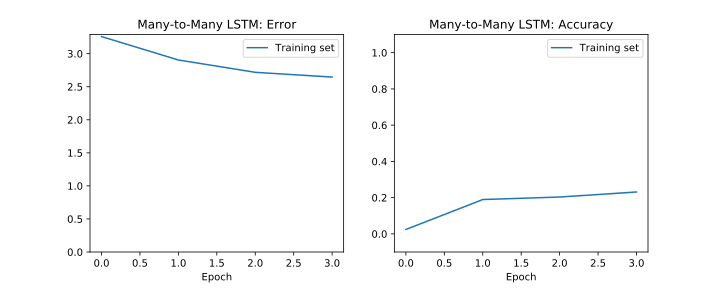

Interrupted! Cleaning up...
       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#    3 |   2.64581 |   0.23125 


KeyboardInterrupt: 

In [53]:
net4.train(10)

In [56]:
def generate4(net, count, len_vocab):
    letters = [cx.choice(len_vocab)] # choose a random letter
    for i in range(count):
        print(decode(letters[-1]), end="")
        outputs = net.propagate(letters)
        if len(cx.shape(outputs)) == 1:
            p = outputs
        else:
            p = outputs[-1]
        letters.append(cx.choice(p=p))
        letters = letters[-40:]

In [57]:
generate4(net4, 500, len_vocab)

 cie a ccl ltnnndeririwsaosdie pthhhar o tctgedr fde loch hgotnhat cer encrccniscttee nurte oto n s l datnaryiearlidnttshaerr eihent no e r d thh  cv  herede rdh ighgcdltd vedlotuotss iee sbewita nde niwro iidwto fvrt ooretedprau leneofneigovn dedghr rccerdefnglog hnieianfn trchhc eutd cervo oletahdt  uin eepfogfiwga ced iihgg ihirthtetatuteoneeonhanf tthbyt tu eawrte at w  afsdltavovrrn gbvpn eh nehneruno  yearsosteirishtd rrncitt ctihgoftscd weoef ra tew waroraodvgeaaie a antdcpd fnnedagt have


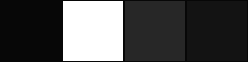

In [60]:
net4.picture([1, 100, 4, 2])


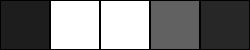

In [63]:
net4.picture([3, 69, 200, 10, 4])

In [64]:
output = net4.propagate(range(4))

In [65]:
cx.shape(net4.dataset.inputs[43:47])

(4, 40)